In [1]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../'))
from collections import defaultdict
import glob
import librosa
from tqdm import tqdm
import numpy as np
import librosa.display
import moviepy.editor as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from sklearn.preprocessing import minmax_scale

In [2]:
AUDIO_DIR = f"{os.path.abspath('./../../')}/eNTERFACE05_Dataset/*/*/*/*.avi"
CONFIG_FILE = f"{os.path.abspath('./../../')}/Audio_Sentiment_Analysis/data/config.json"

In [3]:
config = Configuration.load_json(CONFIG_FILE)

In [4]:
def get_emotion_files(audio_dir) -> defaultdict:
    # { subject: { emotion: { files: [] } } }
    sub_emo_data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    emotions = set()

    for file_path in glob.glob(audio_dir):
        labels =  file_path.split('/')
        emotion = labels[-3]
        emotions.add(emotion)
        subject = labels[-4]
        file_type = labels[-1].split('.')[-1]

        if file_type == 'avi':
            audio_file_path = file_path[:-3] + 'wav'

            # convert file type to wav
            if not os.path.isfile(audio_file_path):
                audio_clip = mp.VideoFileClip(file_path)
                audio_clip.audio.write_audiofile(audio_file_path)

            file_path = audio_file_path

        sub_emo_data[subject][emotion]['files'].append(file_path)

    return sub_emo_data, emotions

In [5]:
# get the files of each subject for each emotion
# sub_emo_data = { subject: { emotion: { files: []} } }
sub_emo_data, emotions = get_emotion_files(AUDIO_DIR)

In [6]:
def extract_features(signal, sr):
    return [
        librosa.feature.zero_crossing_rate(signal)[0, 0],
        librosa.feature.spectral_centroid(signal)[0, 0],
        librosa.feature.melspectrogram(signal, sr=sr, n_mels=config.n_mels),
        librosa.feature.mfcc(y=signal, sr=sr)
    ]

In [7]:
def process_data(sub_emo_data):
    print("Processing 43 subjects audio files:")
    for subj_data in tqdm(sub_emo_data.values()):
        for emotion, emo_data in subj_data.items():
            files = emo_data['files']

            for audio_file in files:
                signal, sr = librosa.load(audio_file, res_type='kaiser_fast')
                emo_data['features'].append(extract_features(signal, sr))
 
    # just for the last file
    print("Emotion: ", emotion)
    print("Total number of samples: ", signal.shape[0])
    print("Sample rate: ", sr)
    print("Audio Duration (s): ", librosa.get_duration(signal))

In [8]:
# extract features from audio files and add it to data structure
# sub_emo_data = { subject: { emotion: { files: [], features: [] } } }
process_data(sub_emo_data)

Processing 43 subjects audio files:


100%|██████████| 43/43 [01:26<00:00,  2.02s/it]

Emotion:  disgust
Total number of samples:  37926
Sample rate:  22050
Audio Duration (s):  1.72


In [9]:
def display_melspecgram(mel_fig, axs, i, emotion, melspecgram):
    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    im = ax.pcolormesh(melspecgram, cmap="magma")
    ax.set_title(emotion)
    mel_fig.colorbar(im, ax=ax)

In [31]:
def analyse_features(sub_emo_data):
    mel_fig, mel_axs = plt.subplots(2, 3, figsize=(16,8))
    mel_fig.suptitle(f"Subject 1 - Log-Mel Magnitude Spectrogram")
    for ax in mel_axs.flat:
        ax.set(xlabel="Time (sample)", ylabel="Log-Mel Bins (mel)")
    for ax in mel_axs.flat:
        ax.label_outer()
    
    # { emotion : { zero_cr: [], spec_cent } }
    emo_data = defaultdict(lambda: defaultdict(list))

    for subject, sub_data in sub_emo_data.items():
        for fig_pos, emotion in enumerate(sub_data):
            features = np.array(sub_data[emotion]['features'])

            emo_data[emotion]['zero_cr'].extend(features[:,0])
            emo_data[emotion]['spec_cent'].extend(features[:,1])

            # using only subject and one file for each emotion for visualization 
            if subject == 'subject 1':
                spec = features[0, 2]
                display_melspecgram(mel_fig, mel_axs, fig_pos, emotion, spec)

    zero_cr_means, spec_cent_means = [], []

    for emotion, features in emo_data.items():
        # scaling features between 0 and 1
        zero_cr_values = minmax_scale(features['zero_cr'], config.scale_range)
        spec_cent_values = minmax_scale(features['spec_cent'], config.scale_range)

        # obtain mean and store it
        zero_cr_means.append(np.mean(zero_cr_values))
        spec_cent_means.append(np.mean(spec_cent_values))


    df = pd.DataFrame(zip(list(emo_data.keys())*6, ["Mean Zero Crossing Rate"]*6+["Mean Spectral Centroid"]*6,\
        zero_cr_means+spec_cent_means), columns=["Emotion", "Mean Values", 'Value'])
    plt.figure(figsize=(10, 6))
    plt.title("Emotions' Features of All Subjects")
    sns.barplot(x="Emotion", hue="Mean Values", y="Value", data=df)
    plt.show()

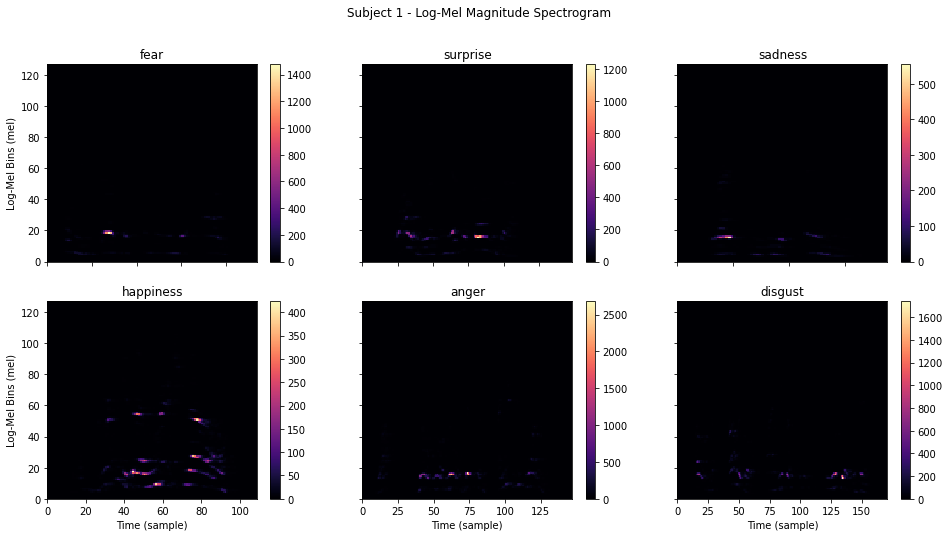

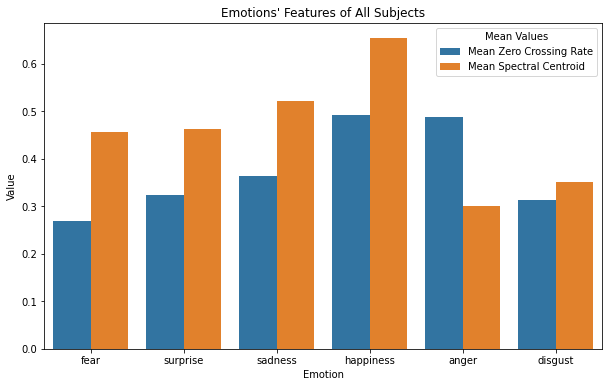

In [32]:
# analyse the extracted features
analyse_features(sub_emo_data)